# Machine Learning for Textual Data - Donald Trump's Tweets
<b> Advanced Numberical Methods and Data Analysis - University of St. Gallen (HSG) - Spring semester 2019 </b>

Elisa Fleissner       (14-350-608)

Lars Stauffenegger    (tbd)

Alexander Steeb       (tbd)

07.05.2019

--------------------------------------------------------------------------------------------

# Project plan
Two models: Word count/frequency (LDA) and word2vec


In [1]:
import sys
print(sys.executable)
print(sys.version)

/usr/local/Cellar/python/3.7.2_2/bin/python3.7
3.7.2 (default, Feb 12 2019, 08:15:36) 
[Clang 10.0.0 (clang-1000.11.45.5)]


## 0. Setup

In [45]:
# import functions
import json
import pandas as pd

import re

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexandersteeb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Data import

JSON into pandas : Per row one tweet - Lars

In [4]:
# Import data from JSON
with open('data/trump.json', encoding="utf8") as json_file:  
    data = json.load(json_file)
    
# this is how you select Date and Cntent of a Tweet (no need to convert it to pandas as we have it in this Dictionary format)
for tweet in range(0, 1):
    print(data[tweet]["created_at"])
    print(data[tweet]["text"])

Sun Mar 24 20:42:19 +0000 2019
No Collusion, No Obstruction, Complete and Total EXONERATION. KEEP AMERICA GREAT!


In [8]:
df = pd.DataFrame()
for tweet in range(0, len(data)):
    df = df.append([[data[tweet]["created_at"],data[tweet]["text"]]], ignore_index=True)

In [9]:
df.columns = ["time", "tweet"]

#arrange data so speeches are ordered by year
df = df.sort_values("time")
df.reset_index(drop=True, inplace=True)

In [10]:
df.sample(10)

,time,tweet
36677,Wed Oct 28 04:47:45 +0000 2015,"""@BarbaraJensen1: @realDonaldTrump @OANN @Grav..."
18343,Thu Apr 14 03:46:29 +0000 2016,Biggest story in politics is now happening in ...
34169,Wed Jun 06 14:37:50 +0000 2012,.@melaniatrump on @QVC tonight at 7PM EST. Tun...
2011,Fri Jan 16 05:08:39 +0000 2015,"""Donald Trump donates land to conservation gro..."
17043,Sun May 04 05:30:33 +0000 2014,The ring announcers are working hard to justif...
22517,Thu May 23 02:02:36 +0000 2013,"""@Gurning_Chimp: @realDonaldTrump @bluejoni No..."
20445,Thu Jan 15 16:03:12 +0000 2015,"""@seandoncito: “@B_Cavaliere: Donald Trump nee..."
33660,Wed Jul 15 14:50:16 +0000 2015,.@BradSteinle Thank you for yr wonderful tweet...
7341,Mon Jan 04 17:31:48 +0000 2016,"I look forward to being in Lowell, Massachuset..."
8466,Mon Jun 10 21:42:01 +0000 2013,@JBradleyDesign1 @CNNMoney @jtotoole Thank you!


## 2. Data cleaning

Data cleaning: Stemming, tokenization, see other documentation
Data visualisation (eg wordcloud)
Data inspection

In [30]:
def preprocessor(text):
    '''removing all punctuation, non-letter characters and white spaces'''
    text.strip()
    text = (re.sub('http[s]?://\S+', '', text))      #remove urls
    text = (re.sub('[\W]+', ' ', text.lower()))      #remove non-word characters and make text lowercase
    text = (re.sub('[\d]+', '', text))               #to remove numbers [0-9]
    text = (re.sub('\n', ' ', text))

    return text.strip()

def tokenizer(text):
    '''split text into single words and return a list of these words'''
    return text.split()

def remove_stopwords(text):
    stop = stopwords.words('english')
    words = [word for word in text.split()]
    stopremoved = [w for w in words if w not in stop]
    return ' '.join(stopremoved)

def tokenizer_porter(text):
    '''Porter stemmer - split text and convert all words back to 
    their stem, e.g. running -> run, return a list of the stemmed words'''
    
    stop = stopwords.words('english')
    porter = PorterStemmer()
    
    stem = [porter.stem(word) for word in text.split()]
    stopremoved = [w for w in stem if w not in stop] #removing common stop words as downloaded from nltk package
    return " ".join(stopremoved)

In [31]:
#apply preprocessor for Wordcloud and merge all preprocessed speeches to one text
wordcloud_df = df['tweet'].apply(preprocessor)
wordcloud_df = wordcloud_df.apply(remove_stopwords)

full_text = ''
for text in wordcloud_df:
    full_text += text

In [38]:
pd.set_option('display.max_colwidth', -1)
df.head()

,time,tweet
0,Fri Apr 01 02:21:02 +0000 2016,#MakeAmericaGreatAgain #Trump2016\nhttps://t.co/aANxirUJJD https://t.co/VlMynYN3sd
1,Fri Apr 01 04:23:25 +0000 2016,"The Club For Growth,which asked me for $1,000,000 in an extortion attempt, just put up a Wisconsin ad with incorrect math.What a dumb group!"
2,Fri Apr 01 04:29:49 +0000 2016,The Club For Growth said in their ad that 465 delegates (Cruz) plus 143 delegates (Kasich) is more than my 739 delegates. Try again!
3,Fri Apr 01 13:42:32 +0000 2011,Be sure to watch The Celebrity Apprentice on Sunday at 9 pm on NBC. It's an episode you'll want to see---and one you won't forget!
4,Fri Apr 01 14:24:46 +0000 2016,The National Border Patrol Council (NBPC) said that our open border is the biggest physical &amp; economic threat facing the American people!


In [39]:
wordcloud_df.head()

0    makeamericagreatagain trump                                                                                     
1    club growth asked extortion attempt put wisconsin ad incorrect math dumb group                                  
2    club growth said ad delegates cruz plus delegates kasich delegates try                                          
3    sure watch celebrity apprentice sunday pm nbc episode want see one forget                                       
4    national border patrol council nbpc said open border biggest physical amp economic threat facing american people
Name: tweet, dtype: object

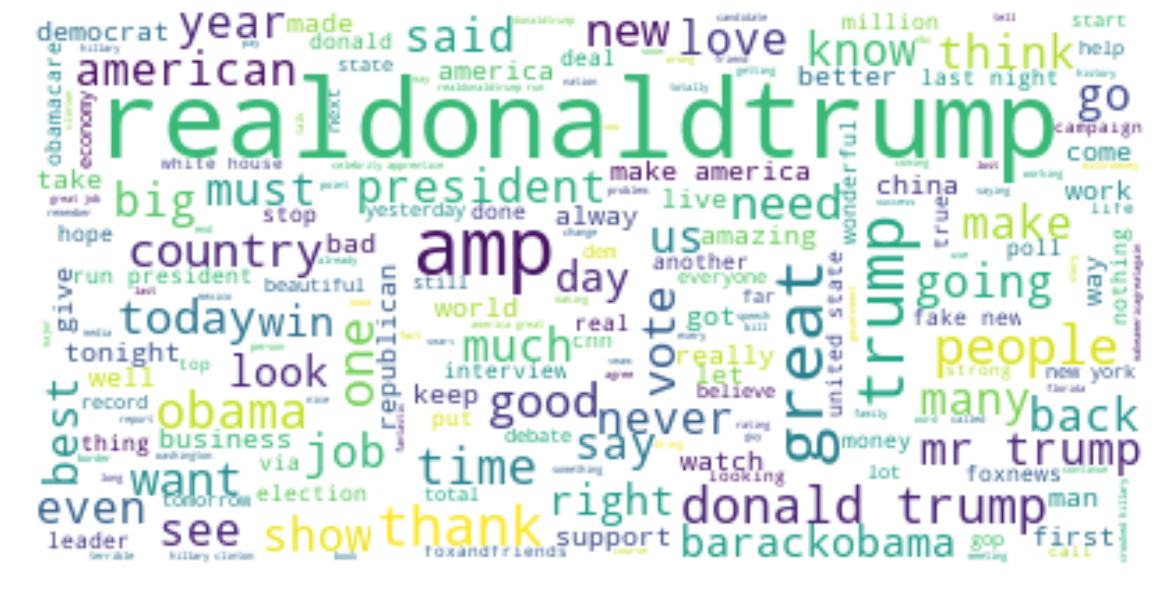

In [34]:
# generate word cloud 
wordcloud = WordCloud(max_font_size=40,background_color="white").generate(full_text)

# display
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 3. Model 1 - LDA

see documentation - Elisa 

In [43]:
#apply preprocessor for LDA

#apply preprocessor to speeches in data frame
df['cleaned'] = df['tweet']
df['cleaned'] = df['cleaned'].apply(preprocessor)

#Processing documents into tokens (incl. stemming and removing stopwords)
df['cleaned'] = df['cleaned'].apply(tokenizer_porter)

In [44]:
df

,time,tweet,text,cleaned
0,Fri Apr 01 02:21:02 +0000 2016,#MakeAmericaGreatAgain #Trump2016\nhttps://t.co/aANxirUJJD https://t.co/VlMynYN3sd,#makeamericagreatagain #trump2016 https://t.co/aanxirujjd https://t.co/vlmynyn3sd,makeamericagreatagain trump
1,Fri Apr 01 04:23:25 +0000 2016,"The Club For Growth,which asked me for $1,000,000 in an extortion attempt, just put up a Wisconsin ad with incorrect math.What a dumb group!","club growth,which ask $1,000,000 extort attempt, put wisconsin ad incorrect math.what dumb group!",club growth ask extort attempt put wisconsin ad incorrect math dumb group
2,Fri Apr 01 04:29:49 +0000 2016,The Club For Growth said in their ad that 465 delegates (Cruz) plus 143 delegates (Kasich) is more than my 739 delegates. Try again!,club growth said ad 465 deleg (cruz) plu 143 deleg (kasich) 739 delegates. tri again!,club growth said ad deleg cruz plu deleg kasich deleg tri
3,Fri Apr 01 13:42:32 +0000 2011,Be sure to watch The Celebrity Apprentice on Sunday at 9 pm on NBC. It's an episode you'll want to see---and one you won't forget!,Be sure watch celebr apprentic sunday 9 pm nbc. it' episod want see---and one forget!,sure watch celebr apprentic sunday pm nbc episod want see one forget
4,Fri Apr 01 14:24:46 +0000 2016,The National Border Patrol Council (NBPC) said that our open border is the biggest physical &amp; economic threat facing the American people!,nation border patrol council (nbpc) said open border biggest physic &amp; econom threat face american people!,nation border patrol council nbpc said open border biggest physic amp econom threat face american peopl
5,Fri Apr 01 14:25:17 +0000 2016,"For the 1st time in American history, America’s 16,500 border patrol agents have issue a presidential primary endorsement—me! Thank you.","1st time american history, america’ 16,500 border patrol agent issu presidenti primari endorsement—me! thank you.",st time american histori america border patrol agent issu presidenti primari endors thank
6,Fri Apr 01 18:45:18 +0000 2016,Does anybody like Lyin' Ted? https://t.co/h78ESEgEYg,doe anybodi like lyin' ted? https://t.co/h78esegeyg,doe anybodi like lyin ted
7,Fri Apr 01 19:12:58 +0000 2016,"My new radio ad, airing today in Wisconsin! See you soon!\n#WIPrimary #Trump2016 \nhttps://t.co/iEbcYqyk3i","My new radio ad, air today wisconsin! see soon! #wiprimari #trump2016 https://t.co/iebcyqyk3i",new radio ad air today wisconsin see soon wiprimari trump
8,Fri Apr 01 21:49:47 +0000 2016,We must build a great wall between Mexico and the United States! https://t.co/05SjuRJFbf,We must build great wall mexico unit states! https://t.co/05sjurjfbf,must build great wall mexico unit state
9,Fri Apr 01 21:52:14 +0000 2016,"Can you believe that Ted Cruz, who has been killing our country on trade for so long, just put out a Wisconsin ad talking about trade?","believ ted cruz, ha kill countri trade long, put wisconsin ad talk trade?",believ ted cruz ha kill countri trade long put wisconsin ad talk trade


In [49]:
X

<37315x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 346359 stored elements in Compressed Sparse Row format>

In [47]:
#Transformation Into Feature Vectors that count how often words appear in different speeches
count = CountVectorizer(stop_words="english", max_df=.9, max_features=10000)
X = count.fit_transform(df['cleaned'].values)  #sparse matrix
    
#fit LDA 
lda = LatentDirichletAllocation(n_components=5, random_state=123, learning_method='batch')
X_topics = lda.fit_transform(X)

lda.components_.shape
#print 5 most important words of every topic
print("The five most important words of the five topics are:")
print()
n_top_words = 7
feature_names = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
    for i in topic.argsort()\
        [:-n_top_words - 1:-1]]))

The five most important words of the five topics are:

Topic 1:
realdonaldtrump thank trump great presid run thi
Topic 2:
obama ha thi amp wa presid countri
Topic 3:
trump great amp rt new today america
Topic 4:
trump hi like wa realdonaldtrump think amp
Topic 5:
great amp big peopl work job tax


## 4. Model 2 - Word2vec

on hold - Alex

## 5. Results